In [0]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 22 21:25:23 2020

@author: Rajalakshmi Selvaraj

Breast cancer develops from the breast tissue and shows different signs such as lumps, change in shape, changes in the texture of skin and pains in some cases. The detection of breast cancer happens through Mammography, ultrasound, analysing tissues, Biopsy and more methods. Each method has its unique way of identification and prone to manual mistakes. The usage of technology in classifying breast cancer improves diagnostic efficiency. The problem of classifying cancer can be done with the histopathology datasets, which is the accurate way of detecting it. 
Over 18 Lakh (Data source: Globocon 2018) breast cancer incidents are reported with a mortality rate of 25%. According to cancer research UK (Cancer Research UK, 2020), Over 50K cases are reported in the UK between 2015-2017, 11k deaths are reported in the same period due to breast cancer. There is a great need for classifying the cancer accurately to avoid more deaths.
In this proposal, the breast cancer classification of benign or malignant is carried out with the help of convolutional neural networks with simple SE-ResNet Model (Jiang Y, n.d.). The approach proposed in this work utilises CNN to extract features of histopathological images and classify the images into benign tumours and malignant tumours. 

Citiation
---------
[1] Jiang Y, Chen L, Zhang H, Xiao X (2019) Breast cancer histopathological image classification using convolutional neural networks with small SE-ResNet module. PLoS ONE 14(3): e0214587. https://doi.org/10.1371/journal.pone.0214587
[2] Mesut Toğaçar, Kutsal Baran Özkurt, Burhan Ergen, Zafer Cömert, BreastNet: A novel convolutional neural network model through histopathological images for the diagnosis of breast cancer, Physica A: Statistical Mechanics and its Applications, Volume
545,2020,123592,ISSN 0378-4371,https://doi.org/10.1016/j.physa.2019.123592.
[3] Deep Residual Learning, https://medium.com/@waya.ai/deep-residual-learning-9610bb62c355,

"""
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/gdrive')

from python_utils import *
import os
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import six
from PIL import Image
import time
from albumentations import *
from skimage.transform import resize

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import logging
import datetime
import errno

#Keras Framework

from keras import models
from keras.models import Model,load_model
from keras import optimizers
from keras.optimizers import *
from keras.optimizers import Adagrad

from keras import layers
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Input, Activation, Dense, Flatten, GlobalAveragePooling2D, Reshape, multiply
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation,Flatten,Dropout,Dense
from keras.layers.merge import add
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard, ModelCheckpoint, Callback

#Tensor Flow as Backend
import tensorflow as tf
from keras import backend as K

#Plotting Metrics
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
import pandas as pd

#Variables used in the code

SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 50
N_SPLITS = 5
SEED = 1881
TRAIN_TEST_RATIO = 0.2
num_classes = 2
BASE_DIR     = "/content/gdrive/My Drive/BreastCancer/breast/"
DATASET_MODE = ["40X", "100X", "200X", "400X"]
base_path = "/content/gdrive/My Drive/"
img_height = 224
img_width = 224
img_channels = 3


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Using TensorFlow backend.


KERAS

Neural Networks with Keras
Keras is a high-level Deep Learning API that allows you to easily build, train and execute of neural networks. Its documentation is available at https://keras.io/. Keras is quite popular because of its ease of use and flexibility. To perform the heavy computations required by neural networks, Keras relies on a computation backend. We will be using Tensorflow as such backend, and for that reason we will be importing keras as follows:

Dataset Pre-Processing

BreakHis dataset comprises of 7909 breast cancer images under two main categories: benign or malignant. 2440 images are available in the Benign class and the malignant class contains 5429 images. Each class has four sub-categories. The sub-categories of benign cancer are listed as Adenosis (A), Fibroadenoma (F), Tubular Adenoma (TA), and Phyllodes Tumor (PT). The four sub-categories of malignant cancer are Ductal Carcinoma (DC), Lobular Carcinoma (LC), Mucinous Carcinoma (MC), and Papillary Carcinoma (PC).

Image Pre-Processing and Augmentation

The RGB images are converted into Arrays. The shape of the array corresponds to the shape of the image. For better attributes extraction, data augmentation is used for the samples. Adding Augmentation parameters such as flip, shift, brightness, rotation and change yield better results.The processed data is split in to train and test data with the split ratio.


In [0]:
class BreastDataset:
    
    """
    input_shape           --> TUPLE.image size
    batch_size            --> INT.data size for every iteration
    orders                --> LIST.images used for cross validation
    base_dir              --> STR.the directory which contains images of Benign and Malignant under directories.
    dataset_mode          --> STR. type of magnification (eg: 4OX, 100X etc)
    seed                  --> INT. This allow to dataset generator to more reproduciable and it ensures that x and y are shuffled with compatible.
    augment               --> BOOL. Augment data or not.
    train_test_ratio      --> Percentage of test data.
    ---------
    GENERAL_CLASSES       --> LIST.["benign", "malignant"]
    BENIGN_SUB_CLASSES    --> LIST.["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
    MALIGNANT_SUB_CLASSES --> LIST.["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]
    """
    
    def __init__(self, input_shape, batch_size, orders, base_dir, dataset_mode, seed, train_test_ratio, augment=True):
        self.SHAPE                 = input_shape
        self.BATCH_SIZE            = batch_size
        self.arr                   = orders
        self.DATASET_MODE          = dataset_mode
        self.SEED                  = seed
        self.TT_RATIO              = train_test_ratio
        self.AUG                   = augment
        
        self.BASE_DIR              = base_dir
        self.GENERAL_CLASSES       = ["benign", "malignant"]
        self.BENIGN_SUB_CLASSES    = ["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
        self.MALIGNANT_SUB_CLASSES = ["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]
        
        
    def get_paths_n_labels(self):

        x      = []
        label = []
        
        for data_mode in self.DATASET_MODE:
            for ix1, a in enumerate(self.GENERAL_CLASSES):
                if ix1 == 0:
                    for ix2, b in enumerate(self.BENIGN_SUB_CLASSES):
                        path1 = self.BASE_DIR+a+"/SOB/"+b
                        for c in os.listdir(path1):
                            path2 = path1+"/"+c+"/"+data_mode
                            for img_name in os.listdir(path2):
                                path3 = path2+"/"+img_name

                                # x
                                img_path = path3 

                                # y - BENIGN OR MALIGNANT
                                main_targets = np.zeros((2), dtype=np.float32) 
                                main_targets[ix1] = 1.

                                # Store the values
                                x.append(img_path)
                                label.append(main_targets)


                if ix1 == 1:
                    for ix2, b in enumerate(self.MALIGNANT_SUB_CLASSES):
                        path1 = self.BASE_DIR+a+"/SOB/"+b
                        for c in os.listdir(path1):
                            path2 = path1+"/"+c+"/"+data_mode
                            for img_name in os.listdir(path2):
                                path3 = path2+"/"+img_name

                                # x
                                img_path = path3

                                # y - BENIGN OR MALIGNANT
                                main_targets = np.zeros((2), dtype=np.float32) 
                                main_targets[ix1] = 1.

                                # Store the values
                                x.append(img_path)
                                label.append(main_targets)
                                #print("Log1:", x,label)                           
        return x, label
    
    def __len__(self):
        return len(self.get_paths_n_labels()[0])
    
    def get_img(self, img_path):
        img = Image.open(img_path)
        return np.array(img)
    
    # initialize the training data augmentation object
    def augmenting(self, img):
        if self.AUG:
            augment = Compose([VerticalFlip(p=0.5),
                               HorizontalFlip(p=0.5),
                               RandomBrightnessContrast(p=0.3),
                               ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0.2, rotate_limit=20)])  
        else:
            augment = Compose([])  

        img = augment(image=img)['image']
        return img
    
    #Resize of the image
    def resize_and_normalize(self, img):
        img = resize(img, self.SHAPE)
        return img
    
    #Shuffling of the data randomly using the SEED parameter
    def get_shuffled_data(self):
        img_paths, labels = self.get_paths_n_labels()

        np.random.seed(self.SEED) 
        np.random.shuffle(img_paths)
        
        np.random.seed(self.SEED) 
        np.random.shuffle(labels)
        
        return img_paths, labels
    
    #Split data into train and test
    def split_train_test(self, get):  # get=={"train","test"}
        img_paths, labels = self.get_shuffled_data()
        x_train, x_test, y_train, y_test = train_test_split(img_paths, labels, test_size=self.TT_RATIO, random_state=self.SEED)
        
        if get=='train':
            
            return x_train, y_train
        
        elif get=='test':
           
            return x_test, y_test
    
    def data_generator(self):
        img_paths, labels = self.split_train_test(get="train")
        
        while True:
            x = np.empty((self.BATCH_SIZE,)+self.SHAPE, dtype=np.float32)
            y = np.empty((self.BATCH_SIZE, 2), dtype=np.float32)

            batch = np.random.choice(self.arr, self.BATCH_SIZE)

            for ix, id_ in enumerate(batch):
                # x
                img_path = img_paths[id_]
                img = self.get_img(img_path)
                img = self.augmenting(img)
                img = self.resize_and_normalize(img)
                  
                # y 
                label = labels[id_]
             
                # Store the values    
                x[ix] = img
                y[ix] = label

            yield x, y
            
            
dataset = BreastDataset(SHAPE, 1, range(4), BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=True)


ROW_AXIS = 1
COL_AXIS = 2
CHANNEL_AXIS = 3


RESNet Model

Residual network gets added as a shortcut connection to the main path. For Identity mapping, the layers are added, and the other layers are derived from the learned model. Residual blocks with the shortcut connection enable to learn an identity function. These facilitate no impact on the training set because of the additional residual blocks getting stacked up.

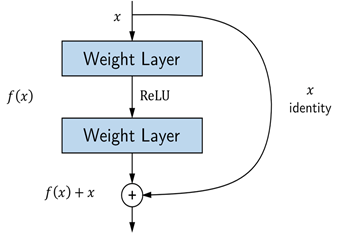


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 112, 112, 64) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

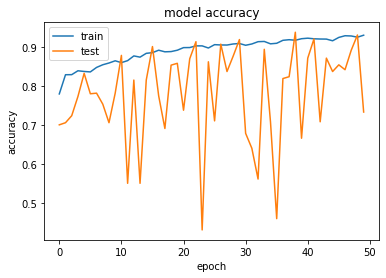

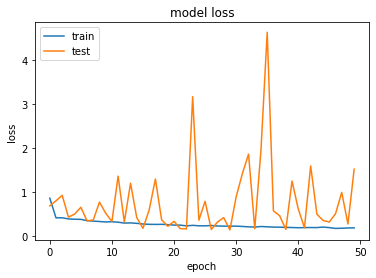

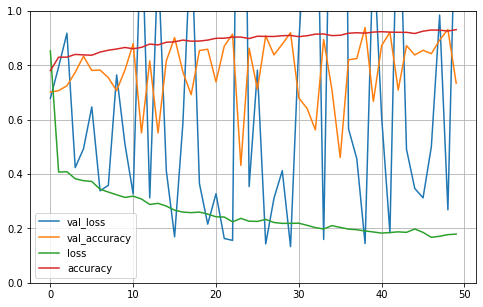

In [3]:
ConvFlag = 1
dropRate = 0.3

def residual_network(x):
  
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `ConvFlag` == 1 this is just a standard convolution
        if ConvFlag == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
  

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _flag=False):
        """
        The Network consists of a stack of residual blocks. 
        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # The residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)
        
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity block used directly when the input and output are of the same dimensions
        if _flag or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization in the residual block
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 128, 256, _flag=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 1024, 2048, _strides=strides)

   
    x = layers.AveragePooling2D((7,7), name="avg_pool")(x)
    x = Flatten()(x)

    # softmax classifier
    x = layers.Dense(2,activation='softmax')(x)

    # return the constructed network architecture
    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())


INIT_LR = 1e-3

kf = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)

for ix, (train_index, test_index) in enumerate(kf.split(range(len(dataset.split_train_test("train")[0])))):
    # initialize the training data                                     
    tg = BreastDataset(SHAPE, BATCH_SIZE, train_index, BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=True)

    # initialize the validation data
    vg = BreastDataset(SHAPE, BATCH_SIZE, test_index , BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=False)
     
    #initialize our Model and Compile with Adaptive Gradient Algorithm as Optimization method    
    opt = Adagrad(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
   
#Early stopping to avoid the overfitting
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True


filepath = '/content/gdrive/My Drive/weights_0206.hdf5'

#Callback with Earlystopping and Model Checkpoint

cbks = [
    EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
    ModelCheckpoint(filepath,monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
]

#Training of the Model

hist = model.fit_generator(tg.data_generator(),
                           steps_per_epoch=len(train_index)//BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=2,
                        callbacks=cbks,
                        validation_data=vg.data_generator(),
                        validation_steps=len(test_index)//BATCH_SIZE)

#Saving the model
model.save('/content/gdrive/My Drive/Resnetcode_0206.h5')
print("Saved model to disk")

#Plotting of Accuracy and Loss graphs

# summarize history for Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Evaluation of the Model

Once the trained model is available, it is evaluated by the testing data, and once it is completed, the trained model is used for prediction of results. In our case, feeding of any image yields classification results as benign or malignant.


In [0]:
# initialize and get the testing data
def get_test_data():
    gen = BreastDataset(SHAPE, BATCH_SIZE, range(1), BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=False).split_train_test("test")
                       
    x = np.empty((len(gen[0]),)+SHAPE, dtype=np.float32)
    y = np.empty((len(gen[1]), 2), dtype=np.float32)
    
    for ix, path in tqdm(enumerate(gen[0])):
        img = np.array(Image.open(gen[0][ix]))
        img = resize(img, SHAPE)

        label = gen[1][ix]

        x[ix] = img
        y[ix] = label
        
    return x, y

In [5]:
#Evaluation of the Model
print("[INFO] evaluating network...")
x, y = get_test_data()
models = []
for i in range(5):
    model = load_model("/content/gdrive/My Drive/Model/Resnetcode_1905.h5")
    print(model.evaluate(x, y, verbose=0))
    models.append(model)

[INFO] evaluating network...


1604it [07:51,  3.41it/s]


[0.2641385066093055, 0.885286808013916]
[0.2641385066093055, 0.885286808013916]
[0.2641385066093055, 0.885286808013916]
[0.2641385066093055, 0.885286808013916]
[0.2641385066093055, 0.885286808013916]


Confusion Matrix

A confusion matrix is a technique for summarizing the performance of a classification algorithm.



For evaluation and performance measurement, the following parameters derived from the confusion matrix are used. 

Accuracy = ((TP+TN))/((TP+FN)+(FP+TN))
	
Precision = TP/((TP+FP))  

F1 Score = ((2xTP))/((2xTP+FP+FN)) 

Recall = ((TP))/((TP+FN)) 


In [0]:
#Function to derive the Confusion Matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    plt.savefig("ConfusionMatrix for Breast_cancer.jpg", dpi=150)
    plt.show()

In [0]:

# Threshold predictions with THRESH_VAL
def threshold_arr(array):
    # Get all value from array
    # Compare calue with THRESH_VAL 
    # IF value >= THRESH_VAL. round to 1
    # ELSE. round to 0
    new_arr = []
    for ix, val in enumerate(array):
        loc = np.array(val).argmax(axis=0)
        k = list(np.zeros((len(val)), dtype=np.float32))
        k[loc]=1
        new_arr.append(k)
        
    return np.array(new_arr, dtype=np.float32)

Plotting of the Confusion Matrix

Accuracy: 0.885286783042394, F1_Score: 0.8700022375739765, Precision: 0.8659663609361798, Recall: 0.8745798675189672


              precision    recall  f1-score   support

           0       0.81      0.84      0.83       515
           1       0.92      0.90      0.91      1089

   micro avg       0.89      0.89      0.89      1604
   macro avg       0.87      0.87      0.87      1604
weighted avg       0.89      0.89      0.89      1604
 samples avg       0.89      0.89      0.89      1604





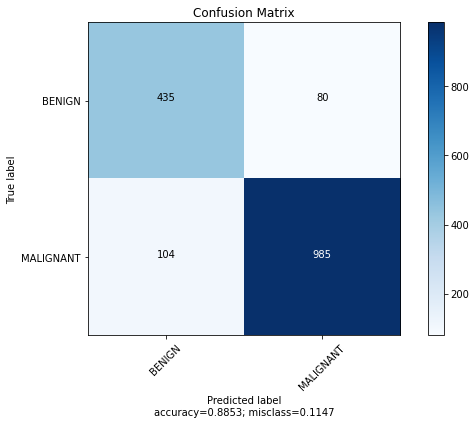

In [8]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability

y_preds = threshold_arr(models[4].predict(x, verbose=0))

results = precision_recall_fscore_support(y, y_preds ,average='macro')
acc = accuracy_score(y, y_preds)

print("Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y, y_preds))
print("\n")
cnf_matrix = confusion_matrix(y.argmax(axis=1), y_preds.argmax(axis=1))

plot_confusion_matrix(cm           = cnf_matrix, 
                      normalize    = False,
                      target_names = ['BENIGN', 'MALIGNANT'],
                      title        = "Confusion Matrix")

Model Prediction

The prediction of the sample with Benign or Malignant is carried out with the help of Model Prediction

In [9]:

# make predictions on the test data by supplying an image

for i in range(5): 
    img = np.array(Image.open(BASE_DIR+"malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-001.png"))
    x = resize(img, SHAPE)
    x = x.reshape((1,) + x.shape) 
    start = time.time()
    prediction = models[4].predict(x, batch_size=1)
    finish = time.time()
    print(threshold_arr(prediction))
    print((finish-start)*1000,"ms")
    print("***")

[[0. 1.]]
229.567289352417 ms
***
[[0. 1.]]
24.38211441040039 ms
***
[[0. 1.]]
25.461435317993164 ms
***
[[0. 1.]]
25.048017501831055 ms
***
[[0. 1.]]
25.285005569458008 ms
***


Plotting of the ROC Curve

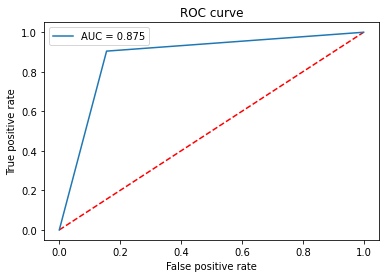

In [10]:
#Plotting the ROC curve

roc_log = roc_auc_score(np.argmax(y, axis=1), np.argmax(y_preds, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y, axis=1), np.argmax(y_preds, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()